## Modeling Exercises

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import acquire
import prepare

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings('ignore')

plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=13)
plt.style.use('bmh')

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

## SAAS

### Acquire and Prep

In [2]:
saas = pd.read_csv('saas.csv')

# Lower case name
saas.columns = [col.lower() for col in saas]

# datatime field
saas.month_invoiced = pd.to_datetime(saas.month_invoiced)

# convert subscription type and amount as int
saas.subscription_type = saas.subscription_type.astype(int)
saas.amount = saas.amount.astype(int)

# Set month_invoiced as index
saas = saas.set_index('month_invoiced')

In [3]:
saas.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0,0
2014-01-31,1000001,5000001,2,10
2014-01-31,1000002,5000002,0,0
2014-01-31,1000003,5000003,0,0
2014-01-31,1000004,5000004,1,5


### saas_eda visuals

amount                       0      5      10    15    20
row_0 subscription_type                                  
2014  0                  166830      0      0     0     0
      1                       0  36179      0     0     0
      2                       0      0  14767     0     0
      3                       0      0      0  5119     0
      4                       0      0      0     0  4647
2015  0                  128488      0      0     0     0
      1                       0  47928      0     0     0
      2                       0      0  17181     0     0
      3                       0      0      0  6239     0
      4                       0      0      0     0  4516
2016  0                  107245      0      0     0     0
      1                       0  48427      0     0     0
      2                       0      0  18612     0     0
      3                       0      0      0  7344     0
      4                       0      0      0     0  4647
2017  0                   93847      0      0     0     0
      1                       0  45678      0     0     0
      2                       0      0  20146     0     0
      3                       0      0      0  7772     0
      4                       0      0      0     0  4846

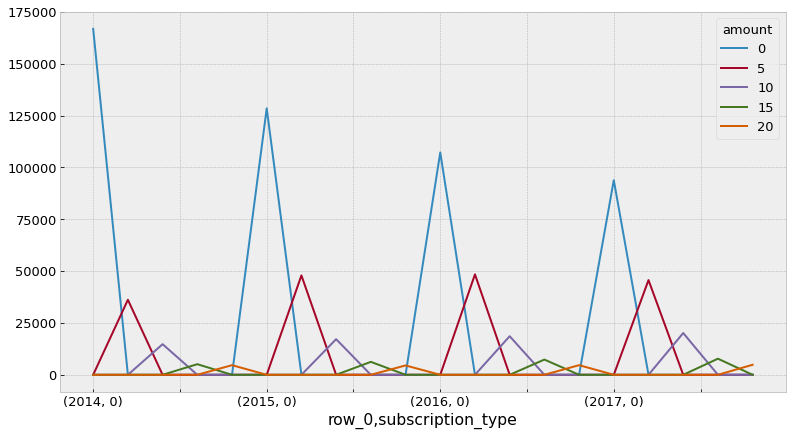

In [4]:
pd.crosstab([saas.subscription_type.index.year, saas.subscription_type], saas.amount).plot()
pd.crosstab([saas.subscription_type.index.year, saas.subscription_type], saas.amount)

amount,0,5,10,15,20
row_0,,,,,
2014,166830,36179,14767,5119,4647
2015,128488,47928,17181,6239,4516
2016,107245,48427,18612,7344,4647
2017,93847,45678,20146,7772,4846


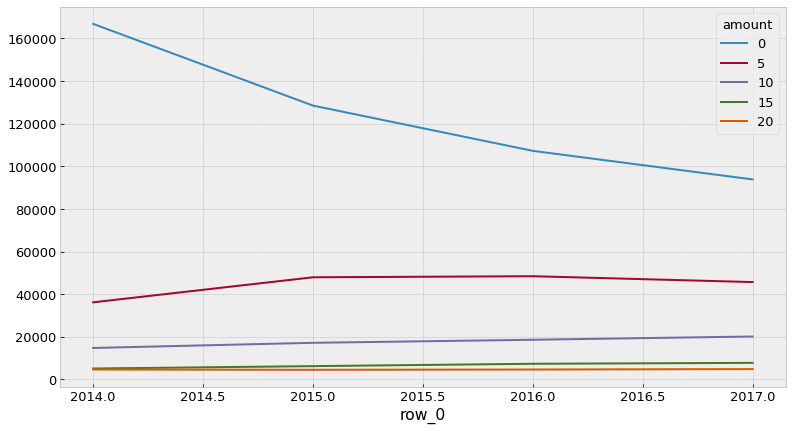

In [5]:
pd.crosstab(saas.subscription_type.index.year, saas.amount).plot()
pd.crosstab(saas.subscription_type.index.year, saas.amount)

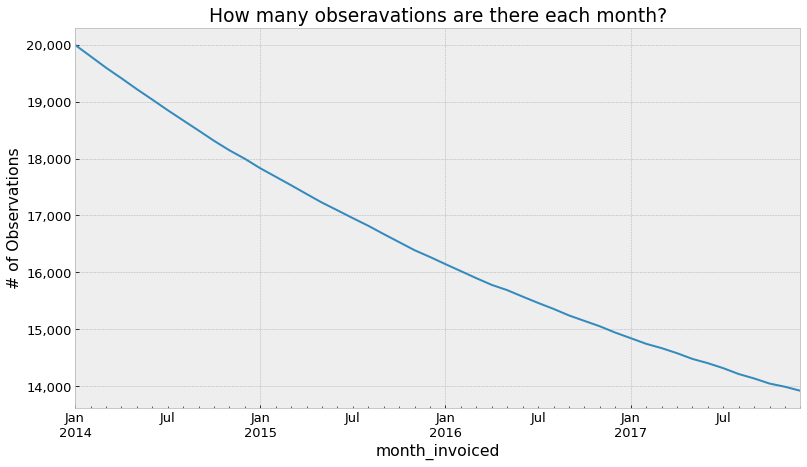

In [6]:
ax = saas.resample('M').size().plot(ylabel='# of Observations')
ax.set(title='How many obseravations are there each month?')
ax.yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

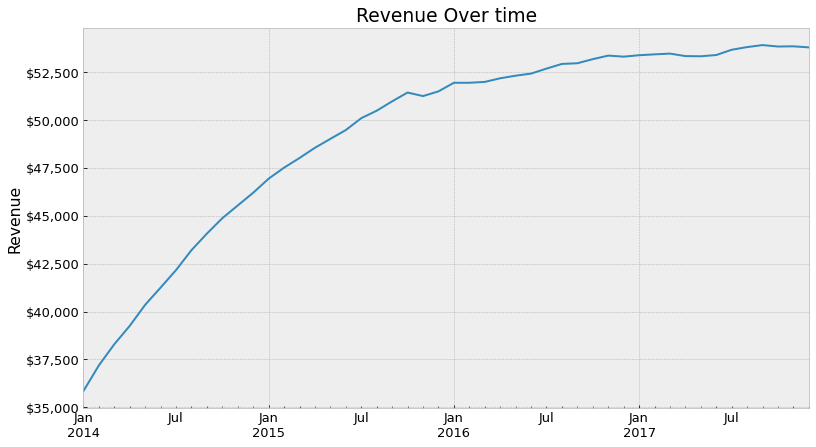

In [7]:
ax = saas.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')
plt.show()

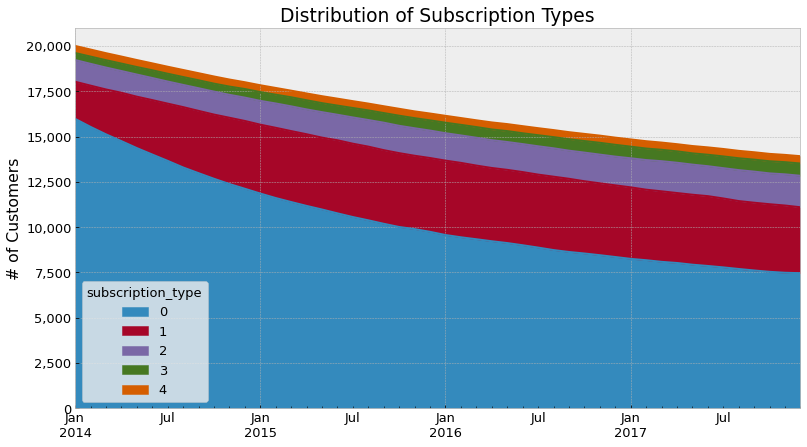

In [8]:
ax = saas.groupby('subscription_type').resample('M').size().T.plot.area()
ax.set(title='Distribution of Subscription Types', xlabel='', ylabel='# of Customers')
ax.yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

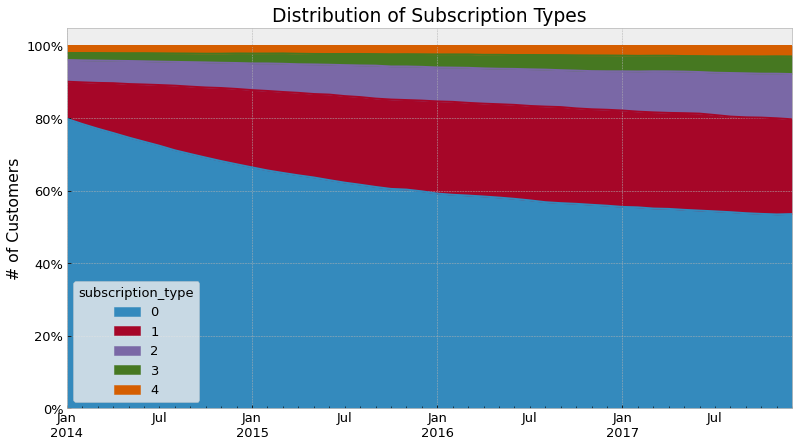

In [9]:
ax = (
    saas.groupby("subscription_type")
    .resample("M")
    .size()
    .T.apply(lambda row: row / row.sum(), axis=1)
    .plot.area()
)
ax.set(title='Distribution of Subscription Types', xlabel='', ylabel='# of Customers')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))

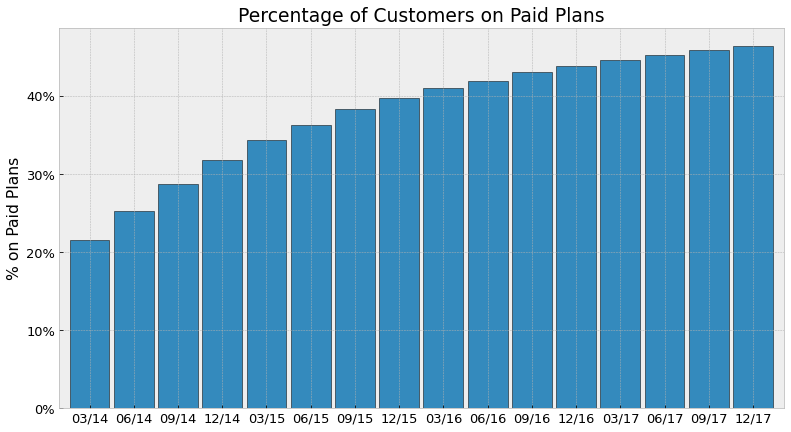

In [10]:
ax = (
    saas.assign(
        paid_plan=lambda saas: saas.subscription_type.apply(lambda x: x > 0)
    )
    .resample('Q')
    .paid_plan.mean()
    .plot.bar(width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%m/%y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)
ax.set(title='Percentage of Customers on Paid Plans', ylabel='% on Paid Plans', xlabel='')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))

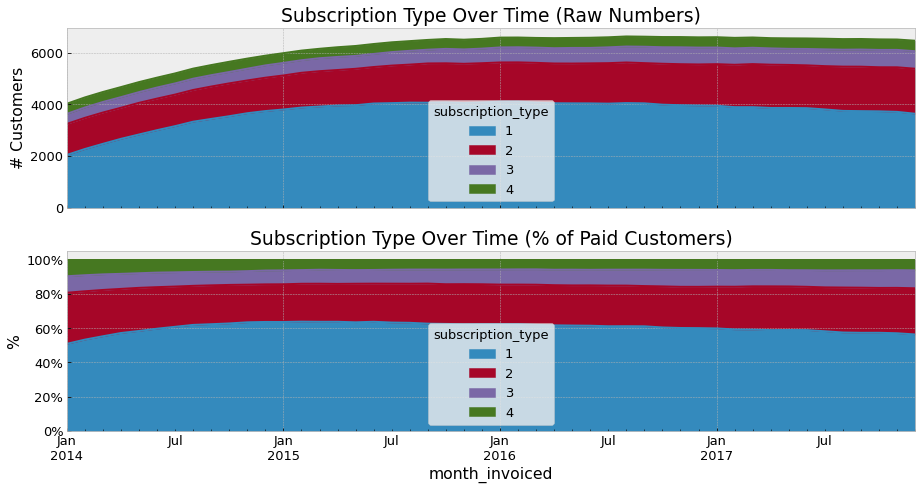

In [11]:
monthly_paid_plans = (
    saas.query('subscription_type > 0')
    .groupby('subscription_type')
    .resample('M')
    .size().T
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

monthly_paid_plans.plot.area(ax=ax1)
ax1.set(title='Subscription Type Over Time (Raw Numbers)', ylabel='# Customers')
monthly_paid_plans.apply(lambda row: row / row.sum(), axis=1).plot.area(ax=ax2)
ax2.set(title='Subscription Type Over Time (% of Paid Customers)', ylabel='%')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
fig.tight_layout()

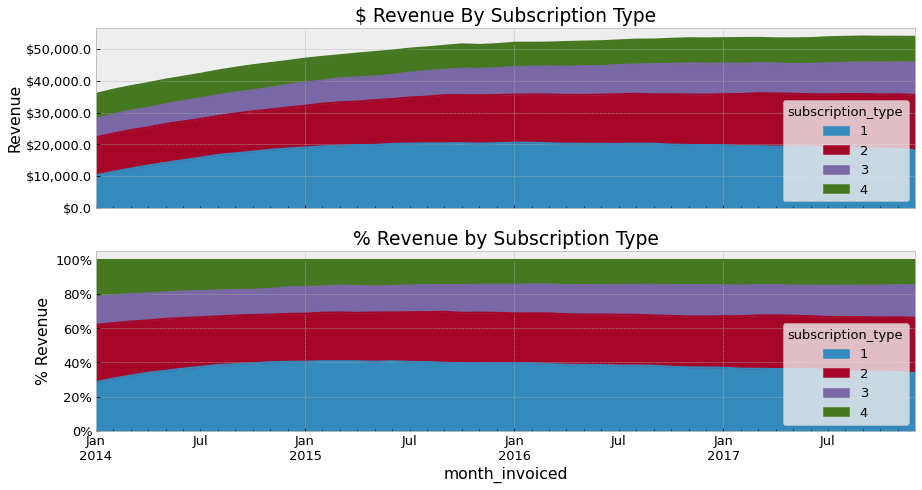

In [12]:
monthly_revenue = (
    saas.query('subscription_type > 0') # filter out free plans
    .groupby('subscription_type')
    .resample('M')
    .amount.sum()
    .unstack(0)
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

monthly_revenue.plot.area(ax=ax1)
ax1.set(title='$ Revenue By Subscription Type', ylabel='Revenue')
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
monthly_revenue.apply(lambda row: row / row.sum(), axis=1).plot.area(ax=ax2)
ax2.set(title='% Revenue by Subscription Type', ylabel='% Revenue')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
fig.tight_layout()

[Text(0, 0.5, 'Revenue'),
 Text(0.5, 1.0, 'Yearly $ Revenue By Subscription Type'),
 Text(0.5, 0, '')]

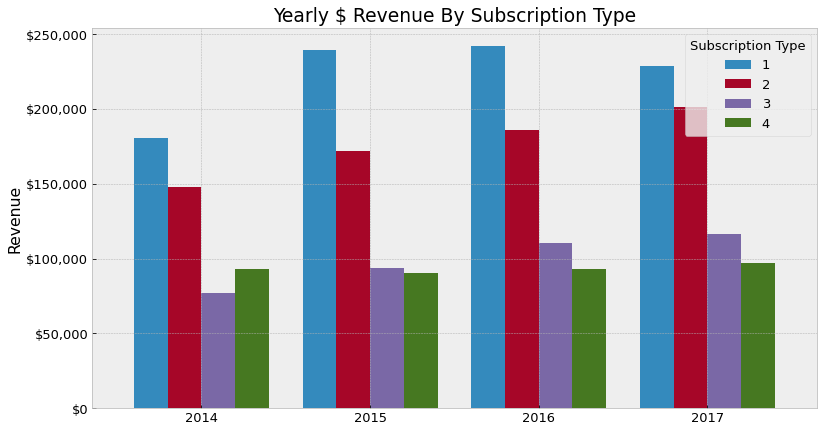

In [13]:
ax = (
    monthly_revenue.resample('Y')
    .sum()
    .plot.bar(width=.8)
)
ax.legend(loc='upper right', title='Subscription Type')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
labels = [pd.to_datetime(t.get_text()).strftime('%Y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)
ax.set(ylabel='Revenue', title='Yearly $ Revenue By Subscription Type', xlabel='')


[Text(0, 0.5, 'Revenue'),
 Text(0.5, 1.0, 'Yearly % Revenue By Subscription Type'),
 Text(0.5, 0, '')]

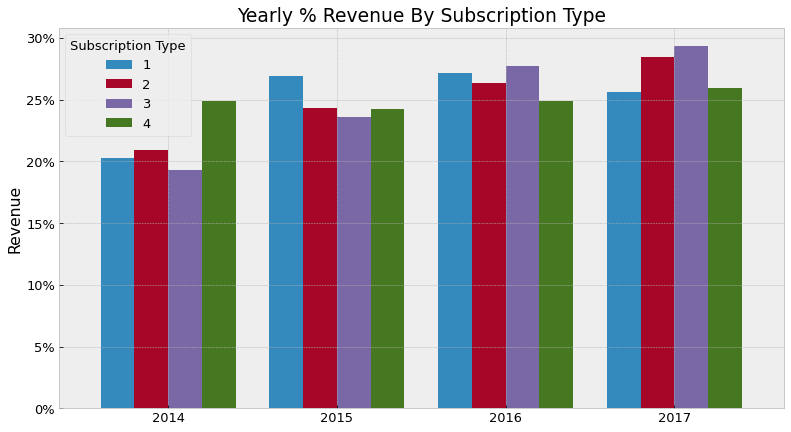

In [14]:
ax = (
    monthly_revenue.resample('Y')
    .sum()
    .apply(lambda row: row / row.sum())
    .plot.bar(width=.8)
)
ax.legend(loc='upper left', title='Subscription Type')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
labels = [pd.to_datetime(t.get_text()).strftime('%Y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)
ax.set(ylabel='Revenue', title='Yearly % Revenue By Subscription Type', xlabel='')


### Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

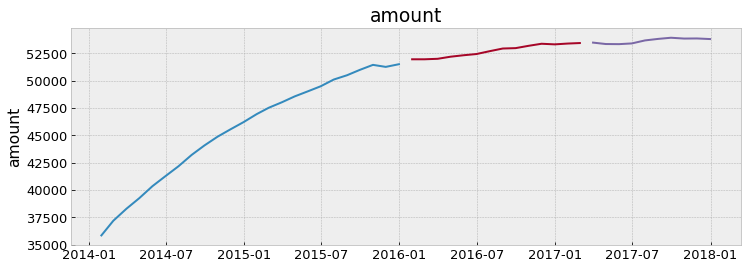

In [15]:
# Narrow focus down to monthly amount sums
df = saas.resample('M')[['amount']].sum()
# Split by percentage
train_size = int(len(df) * 0.5)
validate_size = int(len(df) * 0.3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

# Visualize the split
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [35]:
## Split by period

# period_train = saas[:'2015']
# period_validate = saas['2016']
# period_test = saas['2017']

## Visualize new split

# for col in period_train.columns:
#     plt.figure(figsize=(12,4))
#     plt.plot(period_train[col])
#     plt.plot(period_validate[col])
#     plt.plot(period_test[col])
#     plt.ylabel(col)
#     plt.title(col)
#     plt.show()

### helper functions

In [17]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [18]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [19]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [20]:
df.head()

,amount
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


#### Last Observed Value

In [21]:
amount = train['amount'][-1:][0]
yhat_df = pd.DataFrame({'amount' : [amount]}, index = validate.index)
yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,51505
2016-02-29,51505


amount -- RMSE: 1343


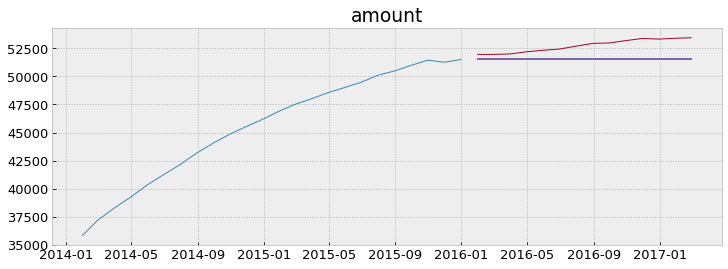

In [22]:
plot_and_eval('amount')

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


#### Simple Average

In [24]:
amount = round(train['amount'].mean(),2)

In [25]:
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index = validate.index)
    return yhat_df

In [26]:
yhat_df = make_predictions(amount)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


amount -- RMSE: 7181


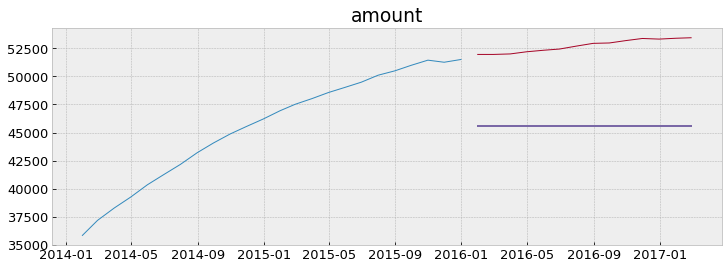

In [27]:
plot_and_eval('amount')

In [28]:
eval_df = append_eval_df(model_type= 'simple average',
                        target_var = 'amount')
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple average,amount,7181.0


#### Moving Average

In [37]:
period = [1,2,3,4,10]

for p in period:
    amount = round(train['amount'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions(amount)
    model_type = str(p) + '_month_moving_avg'
    eval_df = append_eval_df(model_type= model_type, target_var = 'amount')

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple average,amount,7181.0
2,3_month_moving_avg,amount,1436.0
3,1_month_moving_avg,amount,1343.0
4,2_month_moving_avg,amount,1455.0
5,3_month_moving_avg,amount,1436.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0


In [38]:
min_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

In [39]:
eval_df[eval_df.rmse == min_rmse]

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0


#### Holt's Linear Trend Model

amount 



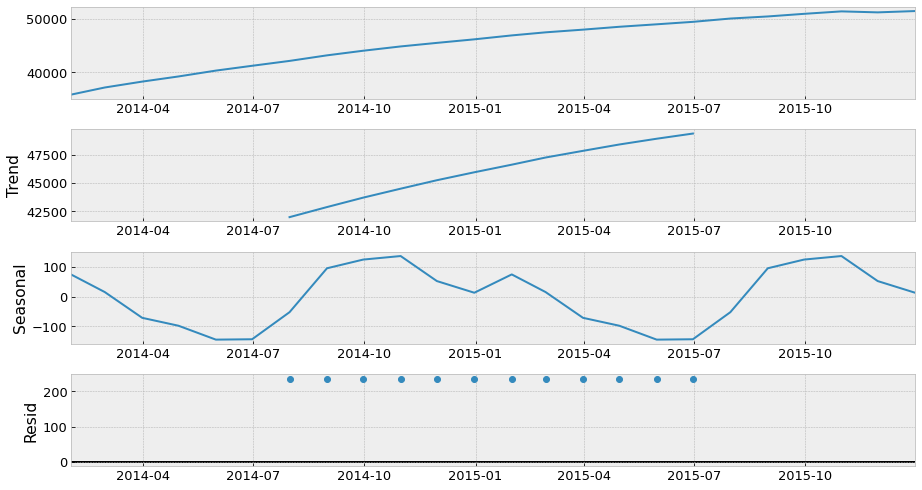

In [40]:
print('amount', '\n')
sm.tsa.seasonal_decompose(train.resample('M').mean()).plot()
plt.show()

#### Based on previous year/month/etc., this is up to you.

## Bonus: Using store item demand

1) Predict 2018 total monthly sales for a single store and/or item by creating a model.

2) Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).

The upper and lower bounds of the predictions are auto generated when using the facebook prophet model, or you could calculate your own using, for example, bollinger bands.

3) Plot the 2018 monthly sales predictions.